# Euler with ExaHyPE 2 
 
A very simple example which demonstrates how to configure a patch-based Finite Volume solver in Peano 4 through the ExaHyPE 2 interface/API. The solver simulates the simple Euler equations, i.e. we rely on the abstract first-order hyperbolic expression

$ \partial Q + \nabla ^T \cdot F(Q) = 0$

In this particular case, this formulation is


$ \frac{\partial}{\partial t} \begin{pmatrix}
\rho\\j\\\ E
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 






To startup ExaHyPE, we need a couple of imports. To make them work, you will have to set your environment variables correctly before you launch the notebook or Python script respectively. On a standard checkout, this is

export PYTHONPATH=../../../python

or

export JUPYTER_PATH=../../../python

respectively. If you run the notebook locally, you might have to set both pathes. If you prefer to run this example without the browser (might be faster), use the ipython3 command:





In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


I first cleanup some local files. Would be a pity to become confused through a lot of output from a previous run.

In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") ]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use (it is examples::exahype2::euler here), we have to give it a name. There are a few more options that we omit here.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "euler"], "finitevolumes" )

## A Finite Volumes solver

Our first step is to use a Finite Volumes solver. So we add this solver to the project. An ExaHyPE mesh can carry multiple solvers at the same time, but we only use one here.

In [4]:
patch_size     = 11
unknowns       = 5
auxiliary_variables = 0   # This could be something alike material parameters. Not required for Euler.
time_step_size = 0.0001
max_h          = 0.1
min_h          = 0.1
project.add_solver(  exahype2.solvers.GenericRusanovFVFixedTimeStepSize("Euler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001) )

## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [5]:
dimensions = 2

if dimensions==2:
  project.set_global_simulation_parameters(
    dimensions,  [0.0,0.0],  [1.0,1.0],
    0.005,        # end time
    0.0, 0.001    # snapshots
  )
else:
  project.set_global_simulation_parameters(
    dimensions, [0.0,0.0,0.0], [1.0,1.0,1.0],
    0.005,         # end time
    0.0, 0.001     # snapshots
  )


## Generate a Peano 4 project

ExaHyPE's Python API does not really "do" something itself. It is a front-end to create and configure a Peano project. Peano in turn has its own Python API. In principle that allows us to use ExaHyPE 2 as a very high level code generator that we later on tweak. We can even use the outcome to inject further functionality that has never been supported by ExaHyPE 2 yet is available in Peano.

For the time being, none of these things is requires. We therefore simply ask ExaHyPE's API to give us a Peano project. This project is then told to generate the "real" C++ code and to translate. Every system will have a bespoke configuration, i.e. its own set of compilers, include paths, ... All of these ingredients have been chosen and tailored when we issued the configure script. Peano's Python API can parse the outcome of the configure instruction and use the same settings for the ExaHyPE/Peano project, too.

The generation can build up reasonably big data structures. If you work on a low-spec machine, you thus might want to tell the generate command to throw away all generated data after the C++ code has been built up.

In [6]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpiicpc
used Fortran compiler is ifort


In [7]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/EulerQ.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.h.template)
write ./celldata/EulerQ.cpp (generated from template /home/tobias/git/Peano/python/peano4/dat

In [8]:
!ls

AbstractEuler.cpp	   Euler.ipynb		   output-parallel.txt
AbstractEuler.h		   Euler.o		   output-symbolic.txt
AbstractEuler.o		   exahype.log-filter	   output.txt
AbstractSymbolicEuler.cpp  example-scripts	   peano4
AbstractSymbolicEuler.h    facedata		   SymbolicEuler.cpp
AbstractSymbolicEuler.o    finitevolumes-main.cpp  SymbolicEuler.h
celldata		   finitevolumes-main.h    SymbolicEuler.o
Constants.h		   Makefile		   trace.out
Euler.cpp		   observers
Euler.h			   output-enclave.txt


To actually implement our PDE, we have to open Euler.cpp in a text editor of our choice and add in the flux functions. We also add some code snippets to set our initial conditions as well as boundary conditions.

<pre>

void examples::exahype2::euler::Euler::adjustSolution(
  double Q[5],
  const tarch::la::Vector<Dimensions,double>&  x,
  const tarch::la::Vector<Dimensions,double>&  h,
  double                                       t
) {
  if (tarch::la::equals(t,0.0) ) {
    logDebug( "adjustSolution(...)", "init volume at " << x << "x" << h << "x" << t );
    // initial conditions
    bool isInTheCentre = ( tarch::la::norm2( x-tarch::la::Vector<Dimensions,double>(0.5) ) < 0.05 );
    //bool isInTheCentre = x(0)<=0.5;
    //bool isInTheCentre = x(1)<=0.5;
    Q[0] = 0.1;  // rho
    Q[1] = 0;    // velocities
    Q[2] = 0;
    Q[3] = 0;
    Q[4] = isInTheCentre ? 1.0 : 0.0; // inner energy
  }
  else {
    // other stuff
  }
}

void examples::exahype2::euler::Euler::eigenvalues(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       lambda[5]
) {
  assertion(normal>=0);
  assertion(normal<Dimensions);
  eigenvalues(Q,faceCentre,volumeH,t,normal,lambda,tarch::multicore::TargetDevice::MayRunOnGPU);

  nonCriticalAssertion2( lambda[0]==lambda[0], faceCentre, normal );
  nonCriticalAssertion2( lambda[1]==lambda[1], faceCentre, normal );
  nonCriticalAssertion2( lambda[2]==lambda[2], faceCentre, normal );
  nonCriticalAssertion2( lambda[3]==lambda[3], faceCentre, normal );
  nonCriticalAssertion2( lambda[4]==lambda[4], faceCentre, normal );
}

void examples::exahype2::euler::Euler::flux(
  double                                       Q[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal,
  double                                       F[5]
) {
  logTraceInWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
  assertion4( normal>=0, faceCentre, volumeH, t, normal );
  assertion4( normal<Dimensions, faceCentre, volumeH, t, normal);
  nonCriticalAssertion9( Q[0]==Q[0], Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );
  nonCriticalAssertion9( Q[1]==Q[1], Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );
  nonCriticalAssertion9( Q[2]==Q[2], Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );
  nonCriticalAssertion9( Q[3]==Q[3], Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );
  nonCriticalAssertion9( Q[4]==Q[4], Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );

  nonCriticalAssertion9( Q[0]>1e-12, Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );

  //
  // If the solution becomes unphysical, the density often becomes zero or
  // negative. I catch them as non-critical, i.e. the code then will complete
  // its timestep and plot the result. While this is convenient for numerical
  // errors (you in particular can spot where problems arise within the domain)
  // programming errors often manifest in negative pressures, too, and should
  // lead to an immediate termination so you can use a debugger to analyse the
  // backtrace. In this case, I simply comment the following assertion in.
  //
  // assertion9( Q[0]>1e-12, Q[0], Q[1], Q[2], Q[3], Q[4], faceCentre, volumeH, t, normal );

  flux(Q,faceCentre, volumeH, t, normal, F, tarch::multicore::TargetDevice::MayRunOnGPU);

  nonCriticalAssertion( F[0]==F[0] );
  nonCriticalAssertion( F[1]==F[1] );
  nonCriticalAssertion( F[2]==F[2] );
  nonCriticalAssertion( F[3]==F[3] );
  nonCriticalAssertion( F[4]==F[4] );

  logTraceOutWith4Arguments( "flux(...)", faceCentre, volumeH, t, normal );
}

void examples::exahype2::euler::Euler::boundaryConditions(
  double                                       Qinside[5],
  double                                       Qoutside[5],
  const tarch::la::Vector<Dimensions,double>&  faceCentre,
  const tarch::la::Vector<Dimensions,double>&  volumeH,
  double                                       t,
  int                                          normal
) {
  logTraceInWith4Arguments( "boundaryConditions(...)", faceCentre, volumeH, t, normal );
  Qoutside[0] = Qinside[0];
  Qoutside[1] = Qinside[1];
  Qoutside[2] = Qinside[2];
  Qoutside[3] = Qinside[3];
  Qoutside[4] = Qinside[4];
  logTraceOut( "boundaryConditions(...)" );
}
</pre>

With all project content generated and befilled with semantics, we can finally translate the code. Note that the above steps have actually produced a Makefile in our ExaHyPE 2 project folder. So we can either translate the project through the notebook, or we can switch to a terminal and invoke the translation manually.

Take care with the translation process if you want to use something fancy that is not active by default. If you have particular modules loaded or environment variables set, then all of these are required before you launch the notebook. On my own system, I need for example

<pre>
source /opt/intel/bin/iccvars.sh intel64
source /opt/intel/itac/2020.0.015/bin/itacvars.sh
source /opt/intel/impi/2019.6.166/intel64/bin/mpivars.sh
</pre>

to use the Intel toolchain. I experienced issues with notebooks where compile errors had not been displayed. Have a look at the terminal: It seems that cerr is not always piped into the notebook window. If that doesn't help, the only remaining option is to execute the whole notebook via ipython3.

In [9]:
parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
compile complete


## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [10]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
run complete


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [11]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.037037
triggered plot at 7.06032025s
started new time step at 8.466574331s
started new time step at 17.111123114s
started new time step at 25.62600997s
started new time step at 33.883897276000006s
started new time step at 42.237453467s
started new time step at 50.584772537s
started new time step at 59.181034329999996s
started new time step at 68.215351681s
started new time step at 77.630077554s
started new time step at 86.01462891300001s
triggered plot at 94.548615573s
started new time step at 95.95617831999999s
started new time step at 104.47926678099999s
started new time step at 113.22626523999999s
started new time step at 121.68407037700001s
started new time step at 129.987453745s
started new time step at 138.274229395s
started new time step at 146.543986392s
started new time step at 154.815351105s
started new time step at 163.09087226s
started new time step at 171.364554761s
triggered plot at 179.62128694299997s
started new time step at 181.032949555s
start

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

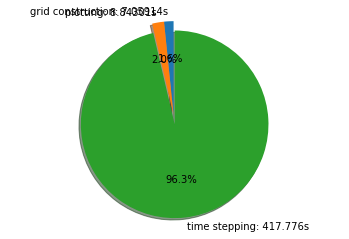

In [12]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

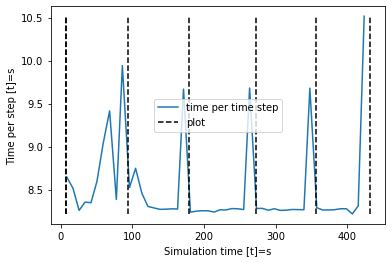

In [13]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Working with a symbolic flux function

Without a doubt, it is cumbersome to implement the fluxes et al manually. In ExaHyPE 2, I give users the opportunity to inject code snippets into the solver generation, i.e. instead of asking ExaHyPE and Peano to give you a C++ template that you then befill with content, you can add in content (copy n paste) through the Python interface. This content in turn can stem from SymPy, when we use SymPy's C code generation. This code generation has to stick to some contentions, but ExaHyPE 2 provides an API/SymPy layer for this:

In [7]:
project.remove_all_solvers()  # clean-up
my_solver = exahype2.solvers.GenericRusanovFVFixedTimeStepSize("SymbolicEuler", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001)
project.add_solver( my_solver )

The above snippet is exactly the same thing we've done before, but this time we keep a reference to the solver. Next, we construct our PDE terms.

In [8]:
import sympy
import exahype2.sympy.FirstOrderConservativePDEFormulation

pde = exahype2.sympy.FirstOrderConservativePDEFormulation(unknowns = 5,dimensions = 3)

#
# Give entries in input vector symbolic names. We first declare the constant
# gamma. Then we tell the solver how we would like to name the Q 
# entries
#
gamma = sympy.symbols( "gamma")
rho   = pde.name_Q_entry( 0, "rho" )    # first scalar is rho
j     = pde.name_Q_entries( 1, 3, "j" ) # entries 1-3 (C counting style) holds j vector
E     = pde.name_Q_entry( 4, "E" )      # energy

#
# Define the equation system
#
p = (gamma - 1 ) * (E-1/2 * exahype2.sympy.dot(j,j) / rho)

pde.F[0,:]   = j
pde.F[1:4,:] = 1/rho * exahype2.sympy.outer(j,j) + p * sympy.eye(3)
pde.F[4,:]   = 1/rho * j * (E+p)

c = sympy.sqrt( gamma * p /rho )
pde.eigenvalue[0] = [ j[0]/rho - c, j[1]/rho - c, j[2]/rho - c ]
pde.eigenvalue[1] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[2] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[3] = [ j[0]/rho, j[1]/rho, j[2]/rho ]
pde.eigenvalue[4] = [ j[0]/rho + c, j[1]/rho + c, j[2]/rho + c ]

pde.substitute_expression( gamma, 1.4 )


Let's display the outcome in a way we can read it:

In [9]:
from IPython.display import Latex
latex_representation = pde.LaTeX()
latex_representation = latex_representation.replace( "rho", "\\rho" )
Latex( latex_representation )


<IPython.core.display.Latex object>

Now we add these routines to our solver. When Peano creates all user code the next time, it will automatically take the functions phrased via SymPy. You can, obviously, mix, i.e. phrase some things (such as the flux) via SymPy and leave others. You'll then get C++ stubs that you have to implement yourself.

In [19]:
volume_centre = sympy.symbols( "volume_centre")

volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 )
#volume_centre = sympy.sqrt( (0.5-pde.x[0])**2 + (0.5-pde.x[1])**2 + (0.5-pde.x[2])**2 )

pde.initial_values[0] = 0.1  # rho
pde.initial_values[1] = 0
pde.initial_values[2] = 0
pde.initial_values[3] = 0
pde.initial_values[4] = sympy.Piecewise( (1.0, volume_centre<0.1), (0.0,True) )


In this simple case, we literally everything symbolic, so there's no need for any manual implementation. The only thing we have to do is to tell the PDE that we actually use only two dimensions in this test case. This is kind of a hack - in most real codes you won't first phrase your PDE in 3d and then "downcast" it to 2d. But it does the job here: 

In [11]:
pde.dimensions=2
my_solver.set_implementation(
  flux=pde.implementation_of_flux(),
  eigenvalues=pde.implementation_of_max_eigenvalue(),
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC(),
  initial_conditions=pde.implementation_of_initial_conditions(invoke_evalf_before_output=False),
  refinement_criterion=exahype2.solvers.GenericRusanovFVFixedTimeStepSize.Empty_Implementation
)

In [12]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpiicpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ././AbstractSymbolicEuler.h (generated from template /home/tobias/git/Peano/python

In [13]:
parallel_builds = 8
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
compile complete


We rerun the code to be able to quantify how expensive the symbolic reformulation is.

In [14]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-symbolic.txt", rebuild_if_required=False )

run application ...
run complete


True

parse output-symbolic.txt
h_min=0.037037
grid construction lasts 3.90764 over 9 steps
plotting lasts 8.14645 over 6 steps
time stepping lasts 66.9678 over 50 steps


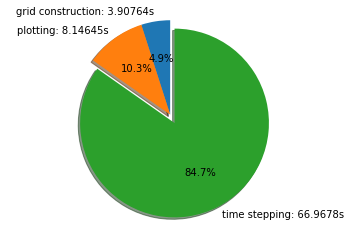

In [15]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-symbolic.txt", verbose=False )
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

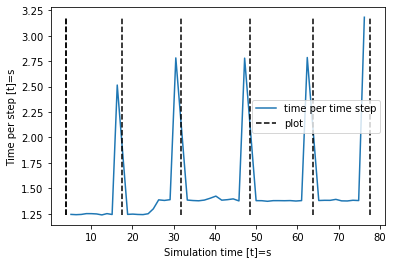

In [16]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

Paraview has a Jupyter notebook plugin now, and we can use it here to inspect the outcomes of the code directly: The installation process is described at https://gitlab.kitware.com/paraview/paraviewjupyterkernel/-/blob/main/README.md. It seems to be fairly straightforward. I haven't however done this on my own machine so far. The other option is to use a stand-alone executable to conver stuff into Paraview. This works if and only if you have configured Peano with Paraview support. I'm also currently working on a Python-based conversion, but this is work in progress. 

No matter which route we follow, we always first have to find out which files we have, as we need the filenames to trigger the postprocessing/vis. Per solver, we should have a file solution-XXX.peano-patch-file. The XXX is the solver name we have specified above.

In [17]:
!ls

AbstractEuler.cpp
AbstractEuler.h
AbstractEuler.o
AbstractSymbolicEuler.cpp
AbstractSymbolicEuler.h
AbstractSymbolicEuler.o
celldata
Constants.h
Euler.cpp
Euler.h
Euler.ipynb
Euler.o
exahype.log-filter
example-scripts
facedata
finitevolumes-main.cpp
finitevolumes-main.h
finitevolumes-main.o
Makefile
observers
output-enclave.txt
output-parallel.txt
output-symbolic.txt
output.txt
peano4
rank--1-convert
solution-SymbolicEuler.peano-patch-file
solution-SymbolicEuler-tree-0-0-rank-0.peano-patch-file
solution-SymbolicEuler-tree-0-1-rank-0.peano-patch-file
solution-SymbolicEuler-tree-0-2-rank-0.peano-patch-file
solution-SymbolicEuler-tree-0-3-rank-0.peano-patch-file
solution-SymbolicEuler-tree-0-4-rank-0.peano-patch-file
solution-SymbolicEuler-tree-0-5-rank-0.peano-patch-file
SymbolicEuler.cpp
SymbolicEuler.h
SymbolicEuler.o
trace.out


### Explicit conversion

This is an explicit, one-off conversion via an executable invocation. You can trigger this via the command line, i.e. via a manual invocation of the convert script. Alternatively, you can use Peano's Python convert wrapper:

In [18]:
import peano4.visualisation

convert = peano4.visualisation.Convert( "solution-SymbolicEuler", True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()


inspect file solution-SymbolicEuler ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-SymbolicEuler.peano-patch-file']
found selectors {'SymbolicEulerQ'}
extract fine grid from solution-SymbolicEuler ... 
inspect file solution-SymbolicEuler ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-SymbolicEuler.peano-patch-file']
found selectors {'SymbolicEulerQ', 'SymbolicEulerQ-fine-grid'}
convert file solution-SymbolicEuler into vtk (vtu binary format) ... 


Now you can invoke Paraview or VisIt in a separate window and study the outcome.

Alternatively, you can use the ipyparaview plugin as yet find it at https://github.com/Kitware/ipyparaview.git. The description of this one reads really cool, but I haven't managed yet to install it on my machine.

## Parallelisation

The parallelisation in ExaHyPE 2 is relatively simple. 

- You have to ensure that configure is called with multithreading and/or MPI support. I recommend never to run MPI without multicore parallelisation. Once you have configured it appropriately, please rebuild all libraries.
- You next have to add a load balancing to your Python project. This will then tell your application to exploit all resources. My default load balancing usually a good starting point. 

In [20]:
load_balancing_quality = 0.9  # quantifies computational ill-balance that we are happy accept
project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(" + str(load_balancing_quality) + ")" )

We now have to rebuild the application and then rerun the code:

In [21]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpiicpc
used Fortran compiler is ifort
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ././AbstractSymbolicEuler.h (generated from template /home/tobias/git/Peano/python

write ././observers/InitGrid.h
write ././observers/InitGrid.cpp
write ././observers/CreateGridButPostponeRefinement2peano4_toolbox_blockstructured_ProjectPatchOntoFaces0.h
write ././observers/CreateGridButPostponeRefinement2peano4_toolbox_blockstructured_ProjectPatchOntoFaces0.cpp
write ././observers/CreateGridButPostponeRefinement2peano4_toolbox_blockstructured_ApplyFunctorOnPatch1.h
write ././observers/CreateGridButPostponeRefinement2peano4_toolbox_blockstructured_ApplyFunctorOnPatch1.cpp
write ././observers/CreateGridButPostponeRefinement2exahype2_grid_SetLabels2.h
write ././observers/CreateGridButPostponeRefinement2exahype2_grid_SetLabels2.cpp
write ././observers/CreateGridButPostponeRefinement.h
write ././observers/CreateGridButPostponeRefinement.cpp
write ././observers/PlotSolution2peano4_toolbox_blockstructured_PlotPatchesInPeanoBlockFormat0.h
write ././observers/PlotSolution2peano4_toolbox_blockstructured_PlotPatchesInPeanoBlockFormat0.cpp
write ././observers/PlotSolution2peano

In [22]:
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
compile complete


I found that this sometimes does not work (on my Ubuntu system - OpenSUSE was fine). In this case, simply call make and the run on the command line. Ensure you pipe the run's output to output.txt.

In [23]:
!ls

AbstractEuler.cpp
AbstractEuler.h
AbstractEuler.o
AbstractSymbolicEuler.cpp
AbstractSymbolicEuler.h
AbstractSymbolicEuler.o
celldata
Constants.h
Euler.cpp
Euler.h
Euler.ipynb
Euler.o
exahype.log-filter
example-scripts
facedata
finitevolumes-main.cpp
finitevolumes-main.h
finitevolumes-main.o
Makefile
observers
output-enclave.txt
output-parallel.txt
output-symbolic.txt
output.txt
peano4
rank--1-convert
solution-SymbolicEuler-0.peano-patch-file
solution-SymbolicEuler-0-SymbolicEulerQ-fine-grid.vtu
solution-SymbolicEuler-0-SymbolicEulerQ.vtu
solution-SymbolicEuler-1.peano-patch-file
solution-SymbolicEuler-1-SymbolicEulerQ-fine-grid.vtu
solution-SymbolicEuler-1-SymbolicEulerQ.vtu
solution-SymbolicEuler-2.peano-patch-file
solution-SymbolicEuler-2-SymbolicEulerQ-fine-grid.vtu
solution-SymbolicEuler-2-SymbolicEulerQ.vtu
solution-SymbolicEuler-3.peano-patch-file
solution-SymbolicEuler-3-SymbolicEulerQ-fine-grid.vtu
solution-SymbolicEuler-3-SymbolicEulerQ.vtu
solution-SymbolicEuler-4.peano-patch

We see that we get a lot of new files. The code does partition the domain now. Each subdomain writes its own snapshot if you trigger a dump. So, overall, the number of output files scales with the number of threads/ranks used.

In [ ]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-parallel.txt", rebuild_if_required=False )

run application ...


In [ ]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-parallel.txt", verbose=False )

In [ ]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

We should see that the time spent int the time stepping has gone down. Plotting is slightly faster in most cases, but it depends on your disk speed. This usually is the limiting factor here. The grid construction becomes more expensive as we do quite some load balancing here. To see exactly this load balancing, we exploit the fact that Peano's load balancing toolbox comes along with some scripts of its own that allow us to analyse the decomposition:

In [ ]:
import sys
sys.path.append( "../../../src/toolbox/loadbalancing/")
import plot_load_distribution

In [ ]:
plot_load_distribution.plot( "output-parallel.txt", verbose=False, plot_remote_cells=False, sum_per_rank=False )

In [ ]:
plot_load_distribution.plot_trees_per_rank( "output-parallel.txt", verbose=False )

For most setups, the trees that are deployed to the cores will be ill-balanced. This is a natural consequence of the tree structure. This implies that we cannot exploit the cores effectively with trees only - we have to use tasks, too. For this, we however need another solver:

# Using enclave tasking

Enclave tasking is a technique where a timestep is broken up into two grid traversals, but the first one focuses on the computation along cells that are time-critical. That 

In [ ]:
project.remove_all_solvers()
project.add_solver(  exahype2.solvers.GenericRusanovFVFixedTimeStepSizeWithEnclaves("Euler", patch_size, unknowns, min_h, max_h, 0.0001) )

In [ ]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


In [ ]:
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

In [ ]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output-enclave.txt", rebuild_if_required=False )

We re-evaluate the runtime with the new run. It is only the runtime that will have changed - the switch to another solver will not affect the load balancing (as we work with the same grid). The code however will now use twice as many steps.

In [ ]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output-enclave.txt", verbose=False )

In [ ]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

In [ ]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Troubleshooting

I had issues with matplotlib on Ubuntu (all worked fine on OpenSUSE right from the start). The snippet below resolved that problem. I had to restart the notebook however.

<pre>
import sys  
!{sys.executable} -m pip install --user matplotlib
</pre>

If you get errors within Peano or ExaHyPE then you might have spotted a bug there. Before you dive into details, please crosscheck which Python version you run. I require Python 3!

In [ ]:
from platform import python_version

print(python_version())